# Addition Prediction

This is the fourth toy example from Jason Brownlee's [Long Short Term Memory Networks with Python](https://machinelearningmastery.com/lstms-with-python/). It demonstrates the solution to a sequence-to-sequence (aka seq2seq) prediction problem. Per section 9.3 of the book:

> The problem is defined as calculating the sum output of two input numbers. This is
challenging as each digit and mathematical symbol is provided as a character and the expected
output is also expected as characters. For example, the input 10+6 with the output 16 would
be represented by the sequences ['1', '0', '+', '6'] and ['1', '6'] respectively.

> The model must learn not only the integer nature of the characters, but also the nature
of the mathematical operation to perform. Notice how sequence is now important, and that
randomly shuffling the input will create a nonsense sequence that could not be related to the
output sequence. Also notice how the number of digits could vary in both the input and output
sequences. Technically this makes the addition prediction problem a sequence-to-sequence
problem that requires a many-to-many model to address.

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
MODEL_FILE = os.path.join(DATA_DIR, "torch-09-addition-predict-{:d}.model")

TRAIN_SIZE = 7500
VAL_SIZE = 100
TEST_SIZE = 500

ENC_SEQ_LENGTH = 8
DEC_SEQ_LENGTH = 2
EMBEDDING_SIZE = 12

BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

## Prepare Data

We first generate a number of random math addition problems of the form a + b + c = d, then stringify them into the sequence of characters as needed by our network. We then left pad these sequences with space. Finally, we one-hot encode these padded strings so they can be fed into an LSTM. The blocks below show these transformations on a small set of random triples.

We then apply these sequence of transformations to create our training and test sets. Each row of input to the network is represented by a sequence of one-hot vectors corresponding to the characters in the alphabet, and each row of output is a sequence of ids corresponding to the characters in the result.

In [3]:
def generate_random_addition_problems(max_num, num_probs):
    lhs_1 = np.random.randint(0, max_num + 1, num_probs)
    lhs_2 = np.random.randint(0, max_num + 1, num_probs)
    lhs_3 = np.random.randint(0, max_num + 1, num_probs)
    rhs = lhs_1 + lhs_2 + lhs_3
    in_seqs, out_seqs = [], []
    for i in range(num_probs):
        in_seqs.append([c for c in "".join([str(lhs_1[i]), "+", str(lhs_2[i]), 
                                            "+", str(lhs_3[i])])])
        out_seqs.append([c for c in str(rhs[i])])
    return in_seqs, out_seqs

input_seq, output_seq = generate_random_addition_problems(10, 5)
for i, o in zip(input_seq, output_seq):
    print(i, o)

['4', '+', '4', '+', '2'] ['1', '0']
['6', '+', '0', '+', '2'] ['8']
['4', '+', '2', '+', '6'] ['1', '2']
['6', '+', '1', '0', '+', '6'] ['2', '2']
['8', '+', '3', '+', '7'] ['1', '8']


In [4]:
def left_pad(chr_list, pad_len, pad_char=' '):
    len_to_pad = pad_len - len(chr_list)
    padded_list = []
    for i in range(len_to_pad):
        padded_list.append(pad_char)
    padded_list.extend(chr_list)
    return padded_list

for i, o in zip(input_seq, output_seq):
    print(left_pad(i, 8), left_pad(o, 2))

[' ', ' ', ' ', '4', '+', '4', '+', '2'] ['1', '0']
[' ', ' ', ' ', '6', '+', '0', '+', '2'] [' ', '8']
[' ', ' ', ' ', '4', '+', '2', '+', '6'] ['1', '2']
[' ', ' ', '6', '+', '1', '0', '+', '6'] ['2', '2']
[' ', ' ', ' ', '8', '+', '3', '+', '7'] ['1', '8']


In [5]:
def one_hot_encode(padded_chr_list, char2idx):
    encodeds = []
    for c in padded_chr_list:
        v = np.zeros(len(char2idx))
        v[char2idx[c]] = 1
        encodeds.append(v)
    return np.array(encodeds)

def one_hot_decode(enc_matrix, idx2char):
    decodeds = []
    for i in range(enc_matrix.shape[0]):
        v = enc_matrix[i]
        j = np.where(v == 1)[0][0]
        decodeds.append(idx2char[j])
    return decodeds

chrs = [str(x) for x in range(10)] + ['+', ' ']
char2idx, idx2char = {}, {}
for i, c in enumerate(chrs):
    char2idx[c] = i
    idx2char[i] = c
for i, o in zip(input_seq, output_seq):
    X = one_hot_encode(left_pad(i, 8), char2idx)
    Y = np.array([char2idx[x] for x in left_pad(o, 2)])
    x_dec = one_hot_decode(X, idx2char)
    print(x_dec, X.shape, Y)

[' ', ' ', ' ', '4', '+', '4', '+', '2'] (8, 12) [1 0]
[' ', ' ', ' ', '6', '+', '0', '+', '2'] (8, 12) [11  8]
[' ', ' ', ' ', '4', '+', '2', '+', '6'] (8, 12) [1 2]
[' ', ' ', '6', '+', '1', '0', '+', '6'] (8, 12) [2 2]
[' ', ' ', ' ', '8', '+', '3', '+', '7'] (8, 12) [1 8]


In [6]:
def generate_data(data_size, enc_seqlen, dec_seqlen):
    input_seq, output_seq = generate_random_addition_problems(10, data_size)
    Xgen = np.zeros((data_size, enc_seqlen, EMBEDDING_SIZE))
    Ygen = np.zeros((data_size, dec_seqlen))
    for idx, (inp, outp) in enumerate(zip(input_seq, output_seq)):
        Xgen[idx] = one_hot_encode(left_pad(inp, ENC_SEQ_LENGTH), char2idx)
        Ygen[idx] = np.array([char2idx[x] for x in left_pad(outp, DEC_SEQ_LENGTH)])
    return Xgen, Ygen

Xtrain, Ytrain = generate_data(TRAIN_SIZE, ENC_SEQ_LENGTH, DEC_SEQ_LENGTH)
Xval, Yval = generate_data(VAL_SIZE, ENC_SEQ_LENGTH, DEC_SEQ_LENGTH)
Xtest, Ytest = generate_data(TEST_SIZE, ENC_SEQ_LENGTH, DEC_SEQ_LENGTH)

print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, Xtest.shape, Ytest.shape)

(7500, 8, 12) (7500, 2) (100, 8, 12) (100, 2) (500, 8, 12) (500, 2)


## Define Network

In [7]:
class AdditionPredictor(nn.Module):
    
    def __init__(self, enc_seqlen, enc_embed_dim, enc_hidden_dim,
                 dec_seqlen, dec_hidden_dim, output_dim):
        super(AdditionPredictor, self).__init__()
        # capture variables needed in forward
        self.enc_hidden_dim = enc_hidden_dim
        self.dec_hidden_dim = dec_hidden_dim
        self.dec_seqlen = dec_seqlen
        self.output_dim = output_dim
        # define network layers
        self.enc_lstm = nn.LSTM(enc_embed_dim, enc_hidden_dim, 1, batch_first=True)
        self.dec_lstm = nn.LSTM(enc_hidden_dim, dec_hidden_dim, 1, batch_first=True)
        self.dec_fcn = nn.Linear(dec_hidden_dim, output_dim)
        self.dec_softmax = nn.Softmax()
    
    def forward(self, x):
        if torch.cuda.is_available():
            he = (Variable(torch.randn(1, x.size(0), self.enc_hidden_dim).cuda()),
                  Variable(torch.randn(1, x.size(0), self.enc_hidden_dim).cuda()))
            hd = (Variable(torch.randn(1, x.size(0), self.dec_hidden_dim).cuda()),
                  Variable(torch.randn(1, x.size(0), self.dec_hidden_dim).cuda()))
        else:
            he = (Variable(torch.randn(1, x.size(0), self.enc_hidden_dim)),
                  Variable(torch.randn(1, x.size(0), self.enc_hidden_dim)))
            hd = (Variable(torch.randn(1, x.size(0), self.dec_hidden_dim)),
                  Variable(torch.randn(1, x.size(0), self.dec_hidden_dim)))

        x, he = self.enc_lstm(x, he)         # encoder LSTM
        x = x[:, -1, :].unsqueeze(1)         # encoder context vector
        x = x.repeat(1, self.dec_seqlen, 1)  # repeat vector decoder seqlen times
        x, hd = self.dec_lstm(x, hd)         # decoder LSTM
        x_fcn = Variable(torch.zeros(x.size(0), self.dec_seqlen, self.output_dim))
        for i in range(self.dec_seqlen):     # decoder LSTM -> fcn for each timestep
            x_fcn[:, i, :] = self.dec_softmax(self.dec_fcn(x[:, i, :]))
        x = x_fcn
        return x

model = AdditionPredictor(ENC_SEQ_LENGTH, EMBEDDING_SIZE, 75,
                          DEC_SEQ_LENGTH, 50, len(chrs))
if torch.cuda.is_available():
    model.cuda()
print(model)

# size debugging
print("--- size debugging ---")
inp = Variable(torch.randn(BATCH_SIZE, ENC_SEQ_LENGTH, EMBEDDING_SIZE))
outp = model(inp)
print(outp.size())

AdditionPredictor (
  (enc_lstm): LSTM(12, 75, batch_first=True)
  (dec_lstm): LSTM(75, 50, batch_first=True)
  (dec_fcn): Linear (50 -> 12)
  (dec_softmax): Softmax ()
)
--- size debugging ---
torch.Size([32, 2, 12])


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

In [9]:
def compute_accuracy(pred_var, true_var, idx2char):
    if torch.cuda.is_available():
        ypred = pred_var.cpu().data.numpy()
        ytrue = true_var.cpu().data.numpy()
    else:
        ypred = pred_var.data.numpy()
        ytrue = true_var.data.numpy()
    pred_nums, true_nums = [], []
    total_correct = 0
    for i in range(ypred.shape[0]):
        true_num = int("".join([idx2char[x] for x in ytrue[i].tolist()]).lstrip())
        true_nums.append(true_num)
        try:
            pred_num = int("".join([idx2char[x] for x in ypred[i].tolist()]).lstrip())
            pred_nums.append(pred_num)
        except ValueError:
            pred_nums.append(true_num + 1)
            continue
    return pred_nums, true_nums, accuracy_score(pred_nums, true_nums)

history = []
for epoch in range(NUM_EPOCHS):
    
    num_batches = Xtrain.shape[0] // BATCH_SIZE
    shuffled_indices = np.random.permutation(np.arange(Xtrain.shape[0]))
    train_loss, train_acc = 0., 0.
    
    for bid in range(num_batches):
        
        # extract one batch of data
        Xbatch_data = Xtrain[shuffled_indices[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]]
        Ybatch_data = Ytrain[shuffled_indices[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        Ybatch = Variable(torch.from_numpy(Ybatch_data).long())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            Ybatch = Ybatch.cuda()
            
        # initialize gradients
        optimizer.zero_grad()

        # forward
        loss = 0.
        Ybatch_ = model(Xbatch)
        for i in range(Ybatch.size(1)):
            loss += loss_fn(Ybatch_[:, i, :], Ybatch[:, i])
        
        # backward
        loss.backward()

        train_loss += loss.data[0]
        
        _, ybatch_ = Ybatch_.max(2)
        _, _, acc = compute_accuracy(ybatch_, Ybatch, idx2char)
        train_acc += acc
        
        optimizer.step()
        
    # compute training loss and accuracy
    train_loss /= num_batches
    train_acc /= num_batches
    
    # compute validation loss and accuracy
    val_loss, val_acc = 0., 0.
    num_val_batches = Xval.shape[0] // BATCH_SIZE
    for bid in range(num_val_batches):
        # data
        Xbatch_data = Xval[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
        Ybatch_data = Yval[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        Ybatch = Variable(torch.from_numpy(Ybatch_data).long())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            Ybatch = Ybatch.cuda()

        loss = 0.
        Ybatch_ = model(Xbatch)
        for i in range(Ybatch.size(1)):
            loss += loss_fn(Ybatch_[:, i, :], Ybatch[:, i])
        val_loss += loss.data[0]

        _, ybatch_ = Ybatch_.max(2)
        _, _, acc = compute_accuracy(ybatch_, Ybatch, idx2char)
        val_acc += acc
        
    val_loss /= num_val_batches
    val_acc /= num_val_batches
    
    torch.save(model.state_dict(), MODEL_FILE.format(epoch+1))
    print("Epoch {:2d}/{:d}: loss={:.3f}, acc={:.3f}, val_loss={:.3f}, val_acc={:.3f}"
          .format((epoch+1), NUM_EPOCHS, train_loss, train_acc, val_loss, val_acc))
    
    history.append((train_loss, val_loss, train_acc, val_acc))

Epoch  1/20: loss=4.603, acc=0.050, val_loss=4.447, val_acc=0.073
Epoch  2/20: loss=4.515, acc=0.055, val_loss=4.446, val_acc=0.073
Epoch  3/20: loss=4.515, acc=0.055, val_loss=4.446, val_acc=0.073
Epoch  4/20: loss=4.512, acc=0.055, val_loss=4.449, val_acc=0.073
Epoch  5/20: loss=4.473, acc=0.058, val_loss=4.452, val_acc=0.073
Epoch  6/20: loss=4.464, acc=0.056, val_loss=4.454, val_acc=0.052
Epoch  7/20: loss=4.462, acc=0.063, val_loss=4.454, val_acc=0.052
Epoch  8/20: loss=4.462, acc=0.060, val_loss=4.453, val_acc=0.062
Epoch  9/20: loss=4.462, acc=0.062, val_loss=4.455, val_acc=0.073
Epoch 10/20: loss=4.463, acc=0.062, val_loss=4.456, val_acc=0.042
Epoch 11/20: loss=4.462, acc=0.060, val_loss=4.453, val_acc=0.052
Epoch 12/20: loss=4.462, acc=0.059, val_loss=4.455, val_acc=0.062
Epoch 13/20: loss=4.462, acc=0.062, val_loss=4.455, val_acc=0.062
Epoch 14/20: loss=4.462, acc=0.059, val_loss=4.453, val_acc=0.073
Epoch 15/20: loss=4.462, acc=0.061, val_loss=4.456, val_acc=0.062
Epoch 16/2

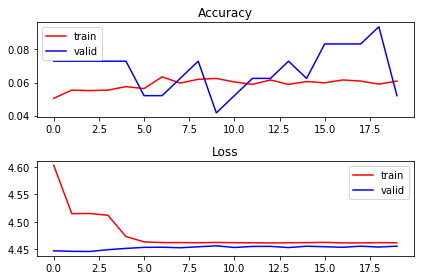

In [10]:
losses = [x[0] for x in history]
val_losses = [x[1] for x in history]
accs = [x[2] for x in history]
val_accs = [x[3] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs, color="r", label="train")
plt.plot(val_accs, color="b", label="valid")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(losses, color="r", label="train")
plt.plot(val_losses, color="b", label="valid")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

Our first test takes the (presumably) best trained model and evaluates it against the test set. The second test takes a slice of the test set and displays the predicted and the true result for each. From the second, it appears that the model has learned to always return a single value.

In [11]:
saved_model = AdditionPredictor(ENC_SEQ_LENGTH, EMBEDDING_SIZE, 75,
                                DEC_SEQ_LENGTH, 50, len(chrs))
saved_model.load_state_dict(torch.load(MODEL_FILE.format(NUM_EPOCHS)))
if torch.cuda.is_available():
    saved_model.cuda()

In [12]:
ylabels, ypreds = [], []
num_test_batches = Xtest.shape[0] // BATCH_SIZE
for bid in range(num_test_batches):
    Xbatch_data = Xtest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    Ybatch_data = Ytest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
    Ybatch = Variable(torch.from_numpy(Ybatch_data).long())
    if torch.cuda.is_available():
        Xbatch = Xbatch.cuda()
        Ybatch = Ybatch.cuda()

    Ybatch_ = saved_model(Xbatch)
    _, ybatch_ = Ybatch_.max(2)

    pred_nums, true_nums, _ = compute_accuracy(ybatch_, Ybatch, idx2char)
    ylabels.extend(true_nums)
    ypreds.extend(pred_nums)

print("Test accuracy: {:.3f}".format(accuracy_score(ylabels, ypreds)))

Test accuracy: 0.046


In [13]:
Xbatch_data = Xtest[0:10]
Ybatch_data = Ytest[0:10]
Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
Ybatch = Variable(torch.from_numpy(Ybatch_data).long())
if torch.cuda.is_available():
    Xbatch = Xbatch.cuda()
    Ybatch = Ybatch.cuda()

Ybatch_ = saved_model(Xbatch)
_, ybatch_ = Ybatch_.max(2)

pred_nums, true_nums, _ = compute_accuracy(ybatch_, Ybatch, idx2char)
Xbatch_var = Xbatch.data.numpy()

for i in range(Xbatch_var.shape[0]):
    problem = "".join(one_hot_decode(Xbatch_var[i], idx2char)).lstrip()
    print("{:>8s} = {:2d} (expected {:2d})".format(problem, pred_nums[i], true_nums[i]))

  8+2+10 = 19 (expected 20)
   9+0+4 = 17 (expected 13)
   0+1+9 = 17 (expected 10)
  10+8+4 = 19 (expected 22)
   3+4+1 = 17 (expected  8)
   0+7+4 = 11 (expected 11)
   2+4+4 = 19 (expected 10)
   3+3+9 = 19 (expected 15)
   1+7+7 = 17 (expected 15)
   7+6+6 = 19 (expected 19)


In [14]:
for i in range(NUM_EPOCHS):
    os.remove(MODEL_FILE.format(i + 1))